# Automatisierte Lösung für OpenAIs LunarLander mit Reinforcement Learning anhand eines Double-Q-Netzwerkes

@Autor Michael Greif

## Verwandte Arbeiten

- Duryea, Ethan, Michael Ganger, und Wei Hu. „Exploring Deep Reinforcement Learning with Multi Q-Learning“. Intelligent Control and Automation 07, Nr. 04 (2016): 129–44. https://doi.org/10.4236/ica.2016.74012.

- Hasselt, Hado. „Double Q-learning“. In Advances in Neural Information Processing Systems, Bd. 23. Curran Associates, Inc., 2010. https://proceedings.neurips.cc/paper/2010/hash/091d584fced301b442654dd8c23b3fc9-Abstract.html.

- Van Hasselt, Hado, Arthur Guez, und David Silver. „Deep Reinforcement Learning with Double Q-Learning“. Proceedings of the AAAI Conference on Artificial Intelligence 30, Nr. 1 (2. März 2016). https://doi.org/10.1609/aaai.v30i1.10295.


## Bibliotheken


1. **Gymnasium**: Eine Bibliothek für die Entwicklung und das Testen von Reinforcement Learning-Umgebungen.
   
2. **Numpy**: Eine Bibliothek für numerische Berechnungen in Python, die Unterstützung für große, mehrdimensionale Arrays und Matrizen bietet.
   
3. **Pytorch**: Eine Open-Source-Bibliothek für maschinelles Lernen, die vor allem für ihre Flexibilität und Benutzerfreundlichkeit bekannt ist.
   
4. **Collections**: Eine eingebaute Python-Bibliothek, die spezielle Container-Datentypen wie OrderedDict und defaultdict bereitstellt.
   
5. **Random**: Eine eingebaute Python-Bibliothek, die Funktionen zur Erzeugung von Zufallszahlen und zur Durchführung zufälliger Operationen bereitstellt.
   
6. **Matplotlib**: Eine Bibliothek zur Erstellung von statischen, animierten und interaktiven Visualisierungen in Python.

7. **tqdm**: Eine Bibliothek zur Erstellung einer Fortschrittsanzeige für Schleifen und Iterationen


In [1]:
import gymnasium as gym         # OpenAI Gym
import numpy as np              # NumPy
import torch                    # PyTorch
import torch.nn as nn           # PyTorch
import torch.optim as optim     # PyTorch
from collections import deque   # Deque for experience replay
import random                   # Random number generator
import matplotlib.pyplot as plt # Matplotlib
from tqdm import tqdm           # Progress bar

## Hyperparameter

Hyperparameter sind entscheidend für den Erfolg eines Reinforcement Learning Modells. Sie beeinflussen, wie gut das Modell lernt und wie schnell es konvergiert.

- Zu hohe **Lernraten** (`learning_rate`) können dazu führen, dass das Modell instabil wird und nicht konvergiert, während zu niedrige Lernraten dazu führen können, dass das Modell zu langsam lernt.
  
- Der **Discount-Faktor** (`gamma`) bestimmt, wie viel zukünftige Belohnungen gewichtet werden. Ein hoher Discount-Faktor bedeutet, dass zukünftige Belohnungen mehr gewichtet werden, während ein niedriger Discount-Faktor bedeutet, dass aktuelle Belohnungen mehr gewichtet werden. 

- Die Exploration-Exploitation-Dilemma ist ein zentrales Problem im Reinforcement Learning. Zu hohe Exploration-Exploitation-Raten können dazu führen, dass das Modell nicht optimal lernt. [Quelle](Muss ich noch einbauen)
  
- Die **Batch-Größe** (`batch_size`)beeinflusst, wie viele Erfahrungen gleichzeitig verarbeitet werden. Eine zu kleine Batch-Größe kann dazu führen, dass das Modell nicht stabil lernt, während eine zu große Batch-Größe dazu führen kann, dass das Modell nicht genug Erfahrungen verarbeitet.
  
- Die **Größe des Replay-Speichers** (`memory_size`) beeinflusst, wie viele Erfahrungen gespeichert werden. Ein zu kleiner Replay-Speicher kann dazu führen, dass das Modell nicht genug Erfahrungen hat, während ein zu großer Replay-Speicher dazu führen kann, dass das Modell nicht effizient lernt.
  
- Die Häufigkeit, mit der das **Zielnetzwerk aktualisiert** wird (`update_target_every`), beeinflusst die Stabilität des Lernens. Ein zu häufiges Aktualisieren kann dazu führen, dass das Modell instabil wird, während ein zu seltenes Aktualisieren dazu führen kann, dass das Modell nicht schnell genug lernt.

In [2]:
# Metadata
env_name = 'LunarLander-v3'             # Environment name
Model_Path = './Model/DQN_Model.pt'     # Path to save the model

# Hyperparameters
num_episodes = 2500                     # Number of episodes to train
learning_rate = 0.0005                  # Learning rate for the optimizer
gamma = 0.99                            # Discount factor
epsilon_start = 1.0                     # Initial exploration rate
epsilon_min = 0.05                      # Minimum exploration rate
epsilon_decay = 0.999                   # Decay rate for exploration
batch_size = 128                        # Size of the batch for training
memory_size = 200000                    # Size of the replay memory
update_target_every = 5                 # Number of episodes to update the target network

## Double-Q-Netzwerk Architektur

**Double Deep Q-Networks (Double DQN)** sind eine Verbesserung des klassischen DQN, die das Problem der **Überschätzung von Q-Werten** beheben.

Anstatt nur ein neuronales Netz zu verwenden, nutzt Double DQN **zwei separate Q-Netzwerke**:

1.  Das **Online-Q-Network** wählt die beste Aktion aus.
2.  Das **Target-Q-Network** bewertet diese Aktion.

Diese Trennung stabilisiert das Training und führt zu besseren Ergebnissen.

Der Code implementiert diese Konzepte mit:

* **`QNetwork`**: Das neuronale Netz zur Schätzung der Q-Werte.
* **`ReplayMemory`**: Speichert Erfahrungen für ein stabileres Training.
* **`DoubleDQNAgent`**: Koordiniert die beiden Netzwerke und den Lernprozess.

In [3]:
# Q-Network
class QNetwork(nn.Module):
    """Q-Network for Double DQN."""
    def __init__(self, input_dim, output_dim):
        """Initialize the Q-Network."""
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        """Forward pass through the network."""
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Replay Memory
class ReplayMemory:
    """Replay Memory for storing transitions."""
    def __init__(self, memory):
        """Initialize the replay memory."""
        self.memory = deque(maxlen=memory)

    def push(self, transition):
        """Push a transition into the memory."""
        self.memory.append(transition)

    def sample(self, batch_size):
        """Sample a batch of transitions from the memory."""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        """Return the current size of the memory."""
        return len(self.memory)

# Doppelte DQN-Agent mit Target Network
class DoubleDQNAgent:
    """Double DQN Agent with Target Network."""
    def __init__(self, obs_dim, n_actions):
        """Initialize the Double DQN Agent."""
        self.q_network = QNetwork(obs_dim, n_actions)
        self.target_network = QNetwork(obs_dim, n_actions)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.memory = ReplayMemory(memory_size)
        self.gamma = gamma

    def update_target_network(self):
        """Update the target network with the current Q-network weights."""
        self.target_network.load_state_dict(self.q_network.state_dict())

    def optimize_model(self, batch_size):
        """Optimize the Q-network using a batch of transitions."""
        
        if len(self.memory) < batch_size:
            return
        
        # Sample a batch of transitions from the replay memory
        transitions = self.memory.sample(batch_size)
        states, actions, rewards, next_states, dones = zip(*transitions)
                
        # Convert to tensors
        states_t = torch.from_numpy(np.array(states, dtype=np.float32))
        actions_t = torch.tensor(actions).unsqueeze(1)
        rewards_t = torch.from_numpy(np.array(rewards, dtype=np.float32))
        next_states_t = torch.from_numpy(np.array(next_states, dtype=np.float32))
        dones_t = torch.from_numpy(np.array(dones, dtype=np.float32))
        
        # Compute the current and target Q-values
        current_q_values = self.q_network(states_t).gather(1, actions_t)
        
        with torch.no_grad():
            # Use the target network to compute the next Q-values
            next_q_actions = self.q_network(next_states_t).max(1)[1].unsqueeze(1)
            next_q_values = self.target_network(next_states_t).gather(1, next_q_actions)

        # Compute the target Q-values
        target_q_values = rewards_t.unsqueeze(1) + (self.gamma * next_q_values * (1 - dones_t.unsqueeze(1)))
        
        # Compute the loss
        loss = nn.functional.mse_loss(current_q_values, target_q_values)

        # Optimize the Q-network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

## Training des Agenten

Der Trainingsprozess ist in eine Hauptschleife unterteilt, die über eine definierte Anzahl von Episoden iteriert:

1.  **Initialisierung der Umgebung und des Agenten:** Zuerst wird die `LunarLander-v3`-Umgebung geladen und ein `DoubleDQNAgent` instanziiert. Dieser Agent ist das Herzstück des Systems und beinhaltet zwei neuronale Netzwerke – ein **Online-Q-Netzwerk** und ein **Ziel-Q-Netzwerk** – sowie einen **Replay-Memory** zur Speicherung von Erfahrungen. Die Explorationsrate `epsilon` wird initialisiert.

2.  **Episoden-Durchlauf:** Jede Episode beginnt mit dem Zurücksetzen der Umgebung auf ihren Anfangszustand. Innerhalb jeder Episode durchläuft der Agent eine festgelegte Anzahl von Schritten:
    * **Aktionsauswahl:** Der Agent wählt eine Aktion basierend auf einer **Epsilon-Greedy-Strategie**. Mit einer Wahrscheinlichkeit von `epsilon` wird eine zufällige Aktion gewählt (Exploration), andernfalls wählt der Agent die Aktion mit dem höchsten Q-Wert, der vom Online-Q-Netzwerk für den aktuellen Zustand vorhergesagt wird (Exploitation). Die `epsilon`-Rate verringert sich im Laufe der Episoden allmählich.
    * **Interaktion mit der Umgebung:** Die gewählte Aktion wird in der Umgebung ausgeführt, was zu einem neuen Zustand, einer Belohnung und einem Signal, ob die Episode beendet wurde, führt.
    * **Speichern der Erfahrung:** Der Übergang (aktueller Zustand, gewählte Aktion, erhaltene Belohnung, nächster Zustand, Episodenende-Flag) wird im `ReplayMemory` des Agenten gespeichert.
    * **Modelloptimierung:** Der Agent optimiert sein Online-Q-Netzwerk in jedem Schritt (oder nach einer bestimmten Anzahl von Schritten). Hierfür wird ein zufälliger Batch von Erfahrungen aus dem Replay-Memory entnommen, um die Gewichte des Netzwerks basierend auf der Double DQN-Formel zu aktualisieren.

3.  **Nach jeder Episode:** Die Gesamtbelohnung der Episode wird protokolliert und `epsilon` wird für die nächste Episode angepasst. In regelmäßigen Abständen (`update_target_every`) wird das **Ziel-Q-Netzwerk** durch Kopieren der Gewichte des Online-Q-Netzwerks aktualisiert. Dies trägt zur Stabilität des Trainings bei.

4.  **Ergebnisdarstellung:** Während des Trainings werden in periodischen Abständen Fortschrittsinformationen (wie die mittlere Belohnung und der `epsilon`-Wert) ausgegeben. Nach Abschluss aller Episoden wird der Zustand des trainierten Q-Netzwerks gespeichert und die Entwicklung der Belohnungen über alle Episoden hinweg grafisch dargestellt, um den Lernerfolg zu visualisieren.

In [4]:
def deep_q_learning_with_double_dqn():
    """Train a Double DQN agent on the LunarLander-v3 environment."""
    env = gym.make(env_name, gravity=-10.0, render_mode='rgb_array')
    agent = DoubleDQNAgent(env.observation_space.shape[0], env.action_space.n)
    epsilon = epsilon_start
    episode_stats = dict(rewards=[], epsilon=[], episodes=[])
    all_rewards = []

    print('Training started...')
    print(f"\n{'Episodes'.center(11)} | {'Mean Reward'.center(10)} | {'Epsilon'.center(18)}")
    print('-' * 45)
    for episode in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0

        for _ in range(1000):
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_t = torch.from_numpy(state)
                    q_values = agent.q_network(state_t)
                    action = torch.argmax(q_values).item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            agent.memory.push((state, action, reward, next_state, terminated))
            state = next_state
            total_reward += reward

            if terminated or truncated:
                break

            agent.optimize_model(batch_size)

        all_rewards.append(total_reward)
        episode_stats['rewards'].append(total_reward)
        episode_stats['epsilon'].append(epsilon)
        episode_stats['episodes'].append(episode + 1)
        epsilon = max(epsilon_min, epsilon_decay * epsilon)

        if episode % update_target_every == 0:
            agent.update_target_network()

        if (episode + 1) % 100 == 0:
            print(f"{episode_stats['episodes'][0]:>4} - {episode_stats['episodes'][-1]:<4} | {np.mean(episode_stats['rewards']):11.5f} | {episode_stats['epsilon'][0]:>5.4f} - {episode_stats['epsilon'][-1]:<5.4f}")
            print('-' * 45)
            episode_stats = dict(rewards=[], epsilon=[], episodes=[])
            
    torch.save(agent.q_network.state_dict(), Model_Path)

    print('\nPlotting results...')
    plt.figure(figsize=(12, 6))
    plt.title('Train Results')
    plt.plot(all_rewards, label='Scores')
    plt.fill_between(range(num_episodes), np.array(all_rewards) - np.std(all_rewards), np.array(all_rewards) + np.std(all_rewards), alpha=0.2)
    plt.legend()
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.grid()
    plt.show()

Training started...

  Episodes  | Mean Reward |      Epsilon      
---------------------------------------------
   1 - 100  |  -158.67769 | 1.0000 - 0.9057
---------------------------------------------
 101 - 200  |  -100.63893 | 0.9048 - 0.8195
---------------------------------------------
 201 - 300  |   -96.85265 | 0.8186 - 0.7414
---------------------------------------------
 301 - 400  |   -81.74701 | 0.7407 - 0.6709
---------------------------------------------
 401 - 500  |   -74.11864 | 0.6702 - 0.6070
---------------------------------------------
 501 - 600  |   -61.29629 | 0.6064 - 0.5492
---------------------------------------------
 601 - 700  |   -43.56287 | 0.5486 - 0.4969
---------------------------------------------
 701 - 800  |   -22.71625 | 0.4964 - 0.4496
---------------------------------------------
 801 - 900  |   -27.46130 | 0.4491 - 0.4068
---------------------------------------------
 901 - 1000 |    23.17257 | 0.4064 - 0.3681
--------------------------------

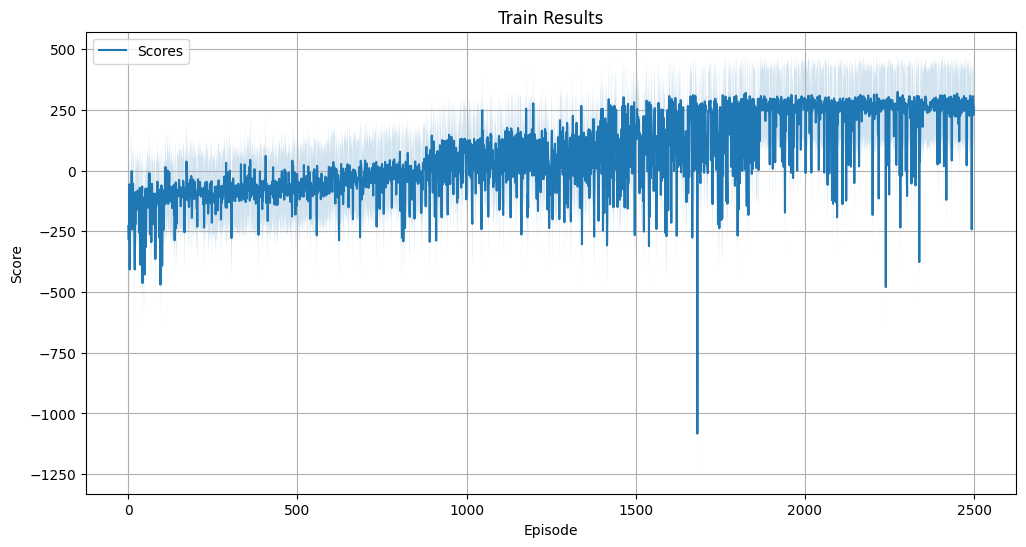

In [5]:
deep_q_learning_with_double_dqn()

**Beobachtungen zum Training:**

* **Lernkurve:** Das Training zeigt eine klare positive Lernkurve. Die mittleren Belohnungen beginnen bei stark negativen Werten (ca. -158) und verbessern sich stetig. Ab etwa Episode 900 überschreitet die mittlere Belohnung die 0-Marke, was darauf hindeutet, dass der Agent anfängt, positive Landungen zu bewerkstelligen.
* **Konvergenz:** Die Scores steigen weiter an und pendeln sich ab etwa Episode 1900 bis 2000 im Bereich von über 200 ein, was auf eine erfolgreiche Konvergenz hinweist. Die maximale Belohnung in LunarLander-v3 liegt bei etwa 300 Punkten, wenn der Lander perfekt auf der Landeplattform landet. Die erreichten Werte von über 200 sind sehr gut.
* **Volatilität:** Die blau schattierte Fläche um die "Scores"-Linie im Plot repräsentiert die Standardabweichung der Belohnungen. Zu Beginn des Trainings ist diese Streuung sehr hoch, was auf eine inkonsistente Leistung des Agenten hindeutet (mal landet er gut, mal stürzt er ab). Im Laufe des Trainings nimmt die Volatilität ab, besonders in den späteren Episoden, was zeigt, dass der Agent konsistenter gute Ergebnisse erzielt.
* **Epsilon-Decay:** Das Epsilon nimmt wie erwartet über die Episoden hinweg ab, von 1.0 auf 0.0907. Dies führt dazu, dass der Agent von einer Phase hoher Exploration zu Beginn (viele zufällige Aktionen) zu einer Phase hoher Exploitation übergeht, in der er hauptsächlich die gelernten, optimalen Aktionen ausführt.

**Effektivität des Trainings:**

Das Training ist als **sehr effektiv** zu bewerten. Der Agent hat erfolgreich gelernt, die LunarLander-Umgebung zu meistern und erreicht konsistent hohe Belohnungen, die nahe an den maximal möglichen Werten liegen. Die stetige Verbesserung der mittleren Belohnung und die Reduzierung der Volatilität im Diagramm bestätigen, dass der Double DQN-Algorithmus mit den gewählten Hyperparametern gut funktioniert hat, um das Problem zu lösen. Das Erreichen von Scores über 200 im LunarLander-v3 ist ein starkes Indiz für einen gut trainierten Agenten.

## Testen des Agenten

Nachdem das Double DQN-Modell erfolgreich trainiert wurde, ist es entscheidend, seine tatsächliche Leistung und Generalisierungsfähigkeit in der Umgebung zu bewerten. Der folgende Testcode dient genau diesem Zweck: Er lädt das zuvor trainierte Modell und lässt es eine Reihe von Episoden in der LunarLander-Umgebung absolvieren, um Metriken wie die durchschnittliche Belohnung, die Erfolgsrate und die Schritte pro Episode zu erfassen. Dabei agiert der Agent ausschließlich nach seinen gelernten Q-Werten, ohne weitere Exploration. Dies ermöglicht eine objektive Einschätzung der Effektivität des Trainings.

In [ ]:
def test_agent(num_episodes=100, render_mode='human'):
    env = gym.make(env_name, gravity=-10.0, render_mode=render_mode)
    agent = QNetwork(env.observation_space.shape[0], env.action_space.n)
    agent.load_state_dict(torch.load(Model_Path))
    agent.eval()
    all_rewards = []
    all_steps = []
    
    print("Testing the agent...")
    for _ in tqdm(range(num_episodes), desc="Testing Agent", unit="episode"):
        state, _ = env.reset()
        total_reward, steps = 0, 0

        for _ in range(1000):
            with torch.no_grad():
                state_t = torch.tensor(state, dtype=torch.float32)
                q_values = agent(state_t)
                action = torch.argmax(q_values).item()

            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            steps += 1

            if terminated or truncated:
                break

        all_rewards.append(total_reward)
        all_steps.append(steps)

    env.close()
    
    print('\nTest Results:')
    print(f"\n{'Metric':<30} {'Value':<10}")
    print('-' * 40)
    print(f"{'Average Reward':<30} {np.mean(all_rewards):.4f}")
    print(f"{'Median Reward':<30} {np.median(all_rewards):.4f}")
    print(f"{'Standard Deviation':<30} {np.std(all_rewards):.4f}")
    print(f"{'Minimum Reward':<30} {np.min(all_rewards):.4f}")
    print(f"{'Maximum Reward':<30} {np.max(all_rewards):.4f}")
    print(f"{'Success Rate (>= 200)':<30} {np.mean(np.array(all_rewards) >= 200)*100:.2f} %")
    print('-' * 40)
    print(f"{'Total Episodes':<30} {num_episodes}")
    print(f"{'Total Steps':<30} {sum(all_steps)}")
    print(f"{'Average Steps per Episode':<30} {np.mean(all_steps):.2f}")
    print(f"{'Max Steps':<30} {np.max(all_steps)}")
    print(f"{'Min Steps':<30} {np.min(all_steps)}")
    print('-' * 40)
    print('Test completed.')
    
    print('\nPlotting results...')
    plt.figure(figsize=(12, 6))
    plt.title('Test Results')
    plt.plot(all_rewards, label='Scores')
    plt.plot([np.mean(all_rewards[:x]) for x in range(1, num_episodes+1)], label='Mean Score')
    plt.plot([np.median(all_rewards[:x]) for x in range(1, num_episodes+1)], label='Median Score')
    plt.fill_between(range(num_episodes), np.array(all_rewards) - np.std(all_rewards), np.array(all_rewards) + np.std(all_rewards), alpha=0.2)
    plt.legend()
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.grid()
    plt.show()

Testing the agent...


Testing Agent: 100%|██████████| 1000/1000 [04:02<00:00,  4.12episode/s]



Test Results:

Metric                         Value     
----------------------------------------
Average Reward                 265.7856
Median Reward                  272.8316
Standard Deviation             38.3608
Minimum Reward                 7.4934
Maximum Reward                 325.9710
Success Rate (>= 200)          94.00 %
----------------------------------------
Total Episodes                 1000
Total Steps                    271598
Average Steps per Episode      271.60
Max Steps                      1000
Min Steps                      102
----------------------------------------
Test completed.

Plotting results...


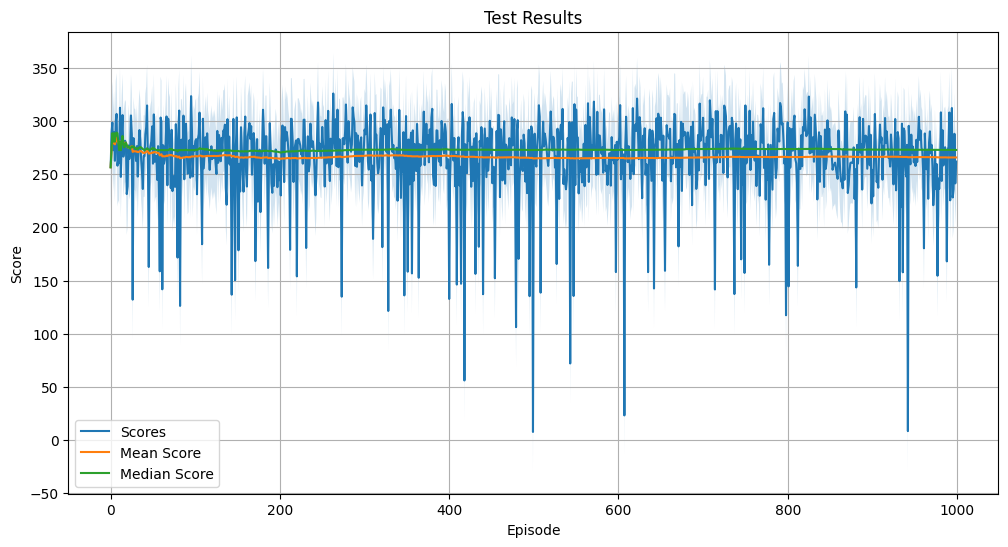

In [7]:
# Test des trainierten Netzwerks
test_agent(num_episodes=1000,render_mode='rgb_array')

**Auffälligkeiten und Bewertung:**

- **Sehr hohe Durchschnitts- und Median-Belohnung:** Mit einem Durchschnittswert von 265.7856 und einem Median von 272.8316 sind die erzielten Belohnungen exzellent. Ein Score über 200 wird in dieser Umgebung oft als erfolgreiche Landung gewertet.
- **Hohe Erfolgsrate:** Eine Erfolgsrate von 94.00 % für Belohnungen von 200 oder mehr ist bemerkenswert und unterstreicht die Robustheit und Konsistenz des Agenten.
- **Geringe Standardabweichung bei hohem Durchschnitt:** Die Standardabweichung von 38.3608 ist im Vergleich zum hohen Durchschnittswert relativ gering. Dies zeigt, dass der Agent nicht nur gute Ergebnisse erzielt, sondern diese auch sehr konstant sind. Die Streuung im Plot ist sichtbar, aber der Großteil der Scores liegt eng um den Mittelwert.
- **Vereinzelte Ausreißer nach unten:** Das Diagramm zeigt, dass es vereinzelt, aber selten, zu sehr geringen Scores (bis ca. 0) kommt. Dies deutet auf gelegentliche Fehlschläge hin, bei denen der Lander abstürzt. Angesichts der sehr hohen Erfolgsrate sind diese jedoch die Ausnahme und nicht die Regel.
- **Stabile Leistung über die Testepisoden:** Sowohl die Mean Score- als auch die Median Score-Linie im Plot sind nahezu flach und verlaufen auf einem hohen Niveau. Dies bestätigt, dass die Leistung des Agenten während der gesamten 1000 Testepisoden stabil und konsistent war. Es gibt keine Anzeichen für ein Nachlassen der Leistung oder ein unvorhergesehenes Verhalten.
- **Effiziente Schrittzahl**: Die durchschnittliche Schrittzahl pro Episode von 271.60 zeigt, dass der Agent relativ effizient landet und nicht unnötig lange im Environment verweilt. Die maximale Schrittzahl von 1000 deutet darauf hin, dass die Episode in einigen Fällen bis zum Zeitlimit lief, ohne dass der Agent vorzeitig abgestürzt ist.

## Fazit

Das trainierte Double DQN-Modell demonstriert eine **herausragende Leistung** in der LunarLander-v3-Umgebung. Nach einer erfolgreichen Trainingsphase, in der der Agent eine deutliche Verbesserung der Belohnungen und eine Reduzierung der Volatilität zeigte, bestätigt die anschließende Testphase die Robustheit und Effizienz des gelernten Verhaltens. Mit einer **Erfolgsrate von 94%** bei der Erzielung hoher Belohnungen und konsistenten Ergebnissen hat der Agent bewiesen, dass er in der Lage ist, die anspruchsvolle Landeaufgabe zuverlässig zu meistern. Dies unterstreicht die Effektivität des Double DQN-Algorithmus und die sorgfältige Auswahl der Hyperparameter für dieses spezielle Problem.